# Case1: Contents of the HTTP request

In [36]:
var dbg = new Debugger("localhost", 25432);  // Using JDI

>> Debugger Info: Try to connect to localhost:25432
>> Debugger Info: Successflly connected to localhost:25432


In [37]:
dbg.run();
Point p = dbg.stopAt("tomcatdemo.App", 18).get(); // Stop at line 18

>> Debugger Info: Debugger started.


Visit http://localhost:8080/TomcatDemo-0.0.1/home once from Google Chrome

In [21]:
DebugResult dr = p.getResults().get("req");
var req = (ObjectInfo) dr.getLatestValue(); // Get the value of the variable req

In [22]:
req.invokeMethod(dbg.thread(), "getMethod");  // HTTP method

return of getMethod="GET"


In [23]:
req.invokeMethod(dbg.thread(), "getRequestURI"); // Request URI

return of getRequestURI="/TomcatDemo-0.0.1/home"


In [24]:
req.invokeMethod(dbg.thread(), "getHeader", "User-Agent"); // User-Agent header

return of getHeader="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.71 Safari/537.36"


# Case: Identifying bottlenecks

In [1]:
var dbg = new Debugger("localhost", 39876, true); // Using ProbeJ

### Set up observation points at the boundary of each section

In [2]:
dbg.run();
String[] vars = {"noOfViews"};
List<Integer> lines = List.of(20, 22, 24, 26, 28);
var points = lines.stream()
                  .map(line -> dbg.watch("tomcatdemo.App", line, vars).get())
                  .collect(Collectors.toList());

Try to connect to localhost:39876
Succeccfully connected to localhost:39876
>> Debugger Info: Debugger started.


Visit http://localhost:8080/TomcatDemo-0.0.2/home 15 times (Please wait for the page to refresh before accessing it)．

### Display of observation results(n=15)

In [3]:
var values =  new ArrayList<ValueInfo>();
points.forEach(p -> {
  var dr = p.getResults().get(vars[0]);
  var latestValue = dr.getLatestValue();
  values.add(latestValue);
  println("value\t:\ttimestamp");
  println(latestValue.getValue()+"\t:\t"+latestValue.getCreatedAt());
})

value	:	timestamp
15	:	2021-11-18T19:39:08.347
value	:	timestamp
15	:	2021-11-18T19:39:08.667
value	:	timestamp
15	:	2021-11-18T19:39:08.725
value	:	timestamp
15	:	2021-11-18T19:39:10.720
value	:	timestamp
15	:	2021-11-18T19:39:10.927


### Visualization of processing time for each section

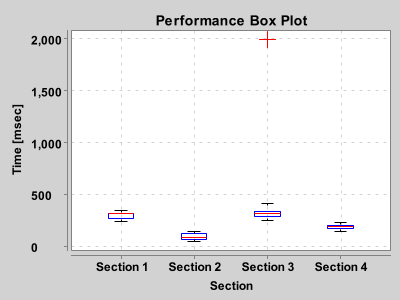

In [4]:
import java.time.LocalDateTime;
import java.time.temporal.ChronoUnit;
import org.knowm.xchart.style.BoxStyler.BoxplotCalCulationMethod;
// the number of access 
int maxSize = points.get(0).getResults().get(vars[0]).getValues().size();
// create chart
BoxChart chart = new BoxChartBuilder().width(400).height(300).title("Performance Box Plot")
                                      .xAxisTitle("Section").yAxisTitle("Time [msec]").build();
for (int i = 0; i < 4; i++) {
    List<Double> list = new ArrayList<>();
    var vs0 = points.get(i).getResults().get(vars[0]).getValues(); // get a start probe point 
    var vs1 = points.get(i+1).getResults().get(vars[0]).getValues(); // get a end probe point
    for (int j = 0; j < maxSize; j++) {
        var v0 = vs0.get(j); // get values at the start probe point
        var v1 = vs1.get(j); // get values at the end probe point
        Long diff = ChronoUnit.MILLIS.between(v0.getCreatedAt(), v1.getCreatedAt()); // get time diff
        list.add(Double.valueOf(diff));
    }
    // series
    chart.addSeries("Section "+(i+1), list);
}

// choose a calculation method
chart.getStyler().setBoxplotCalCulationMethod(BoxplotCalCulationMethod.N_LESS_1_PLUS_1);
chart.getStyler().setToolTipsEnabled(true);
BitmapEncoder.getBufferedImage(chart);

### Survey results
- The bug is in **Section 3** 

In [5]:
dbg.exit();

>> Debugger Info: Debugger exited.


322.0
88.0
320.0
208.0


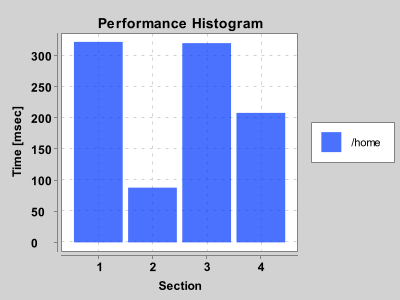

In [4]:
import java.time.temporal.ChronoUnit;

var x = new ArrayList<Double>();
var y = new ArrayList<Double>();

// Formatting data
for (int i = 0; i < values.size()-1; i++) {
  x.add((double) i+1);
  y.add((double) (ChronoUnit.MILLIS.between(values.get(i).getCreatedAt(), values.get(i+1).getCreatedAt())));
  println(y.get(i));
}

// Generating a diagram
CategoryChart chart = new CategoryChartBuilder().width(400).height(300).title("Performance Histogram")
                                                .xAxisTitle("Section").yAxisTitle("Time [msec]").build();
// Series
chart.addSeries("/home", x, y);
BitmapEncoder.getBufferedImage(chart);

## Visualization by Grafana

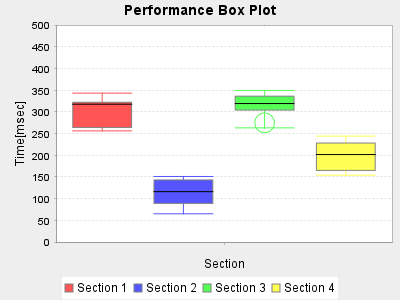

In [33]:
import java.time.LocalDateTime;
import java.time.temporal.ChronoUnit;
int maxSize = points.get(0).getResults().get(vars[0]).getValues().size();
var dataset = new DefaultBoxAndWhiskerCategoryDataset();
for (int i = 0; i < 4; i++) {
    List<Double> list = new ArrayList<>();
    var vs0 = points.get(i).getResults().get(vars[0]).getValues(); // get a start probe point 
    var vs1 = points.get(i+1).getResults().get(vars[0]).getValues(); // get a end probe point
    for (int j = 0; j < maxSize; j++) {
        var v0 = vs0.get(j); // get values at the start probe point
        var v1 = vs1.get(j); // get values at the end probe point
        Long diff = ChronoUnit.MILLIS.between(v0.getCreatedAt(), v1.getCreatedAt()); // get time diff
        list.add(Double.valueOf(diff));
    }
    //BoxAndWhiskerItem item = BoxAndWhiskerCalculator.calculateBoxAndWhiskerStatistics(list);
    //var data = new BoxAndWhiskerItem(item.getMean(), item.getMedian(), item.getQ1(), item.getQ3(), item.getMinRegularValue(), item.getMaxRegularValue(), item.getMinOutlier(), item.getMaxOutlier(), item.getOutliers());
//     list.forEach(it->{
//         println(it);
//     });
//     item.getOutliers().forEach(it-> {
//        println(it); 
//     });
//     println("min:"+item.getMinOutlier());
//     println("max:"+item.getMaxOutlier());
    dataset.add(list, "Section " + (i+1), "");
}

var xAxis = new CategoryAxis("Section");
var yAxis = new NumberAxis("Time[msec]");
//yAxis.setAutoRangeIncludesZero(false);
yAxis.setRange(0, 500);
BoxAndWhiskerRenderer renderer = new BoxAndWhiskerRenderer();
renderer.setFillBox(true);
renderer.setMeanVisible(false);
renderer.setMedianVisible(true);
CategoryPlot plot = new CategoryPlot(dataset, xAxis, yAxis, renderer);
JFreeChart chart = new JFreeChart(
    "Performance Box Plot",
    new Font("SansSerif", Font.BOLD, 14),
    plot,
    true
);
chart.createBufferedImage(400, 300)

In [20]:
maxSize

10

In [10]:
// Elasticsearch用のExporterを作成
var esExporter = new ElasticsearchExporter("http://localhost", 9200, "sample", "09:00");

In [ ]:
for (int i = 0; i < values.size(); i++) {
  var value = values[i];　// 観測情報の取り出し
  var section = String.valueOf(i%5 + 1); // セクションの割り振り
  // データ整形　ValueInfoFactory.create(name, stratum, jValue, value, dateTime)
  var vi = ValueInfoFactory.create("noOfViews", 0, null, section, value.getCreatedAt());
  esExporter.update(vi); // データ登録
}

In [15]:
esExporter.postJson();　// データ送信

In [18]:
esExporter.stop();

In [13]:
import java.time.LocalDateTime;
var vi = ValueInfoFactory.create("sample", 0, null, "1", LocalDateTime.now());
esExporter.update(vi);

0

In [22]:
var values = p.getResults().entrySet().stream().map(e->e.getValue().getLatestValue()).collect(Collectors.toList());

CompilationException: 

In [ ]:
import java.time.LocalDateTime;
import java.time.temporal.ChronoUnit;
esExporter.setSuppressError(true);
int maxSize = points.get(0).getResults().get(vars[0]).getValues().size();
for (int i = 0; i < maxSize; i++) {
  for (int codePoint = 0; codePoint < points.size()-1; codePoint++) {
    var p0 = points.get(codePoint); // get a start probe point 
    var p1 = points.get(codePoint+1); // get a end probe point
    var v0 = p0.getResults().get(vars[0]).getValues().get(i); // get values at the start probe point
    var v1 = p1.getResults().get(vars[0]).getValues().get(i); // get values at the end probe point
    Long diff = ChronoUnit.MILLIS.between(v0.getCreatedAt(), v1.getCreatedAt()); // get time diff
    var vi = ValueInfoFactory.create(String.valueOf(codePoint+1), 0, null, diff.toString(), LocalDateTime.now());
    esExporter.update(vi);
  }
}

In [ ]:
class CustomBoxAndWhiskerRenderer extends BoxAndWhiskerRenderer {
    
}
private void createBoxPlotChart(OutputStream out, Object data)
            throws Exception {

        ChartRenderingInfo info = new ChartRenderingInfo();
        ByteArrayOutputStream baos = new ByteArrayOutputStream();
        byte[] ptsImageBytes = null;

        DefaultBoxAndWhiskerCategoryDataset boxAndWhiskerCategoryDS = createBoxAndWhiskerCategoryDataSet();

        JFreeChart chart = ChartFactory.createBoxAndWhiskerChart(selectedFlight
                + " - Time on Hold", "Arrival Time (Days)",
                "Hold Time (Mins)", boxAndWhiskerCategoryDS, true); 


        NumberAxis rangeAxis = (NumberAxis) chart.getCategoryPlot()
                .getRangeAxis();
        rangeAxis.setStandardTickUnits(NumberAxis.createIntegerTickUnits());        
        rangeAxis.setAutoRangeIncludesZero(true);


        CategoryAxis domainAxis = chart.getCategoryPlot().getDomainAxis();

        BoxAndWhiskerRenderer renderer = (BoxAndWhiskerRenderer) chart.getCategoryPlot().getRenderer();
        //renderer.setFillBox(false);        
        renderer.setMeanVisible(false);
        renderer.setUseOutlinePaintForWhiskers(false);  
        renderer.setMedianVisible(false);             


        if(boxAndWhiskerCategoryDS.getRowCount()>8){
            domainAxis.setCategoryLabelPositions(CategoryLabelPositions
                    .createUpRotationLabelPositions(Math.PI / 5.0));
        }       

        chart.getCategoryPlot().setBackgroundPaint(Color.white);
        chart.getCategoryPlot().setDomainGridlinePaint(Color.gray);
        chart.getCategoryPlot().setRangeGridlinePaint(Color.gray);
        chart.getCategoryPlot().setOutlineVisible(false);

        BufferedImage pageImage = chart.createBufferedImage(CHART_WIDTH,
                CHART_HEIGHT, BufferedImage.TYPE_INT_BGR, info);
        ImageIO.write(pageImage, IMAGE_TYPE, baos);
        baos.flush();
        if (null != baos) {
            ptsImageBytes = baos.toByteArray();
        }

        ImageIO.write(pageImage, IMAGE_TYPE, out);

    }

    private DefaultBoxAndWhiskerCategoryDataset createBoxAndWhiskerCategoryDataSet()
            throws ParseException {     


        DefaultBoxAndWhiskerCategoryDataset dataset = new DefaultBoxAndWhiskerCategoryDataset();

        for (String graph : graphList) {            

            final List<Double> list = new ArrayList<Double>();
            for (ereportDto ereportDto : holdTimeRptList) {
                if (ereportDto != null && ereportDto.getHoldTime() != 0
                        && ereportDto.getGraphTime() != null
                        && ereportDto.getGraphTime().equalsIgnoreCase(graph)) {                 

                    double medianVal=ereportDto.getGraphHoldEntry()+((ereportDto.getGraphHoldExit()-ereportDto.getGraphHoldEntry())/2);

                    list.add(new Double(ereportDto.getGraphTimeAt120NM()));                             
                    list.add(new Double(ereportDto.getGraphHoldEntry()));
                    list.add(new Double(medianVal));                    
                    list.add(new Double(ereportDto.getGraphHoldExit()));                    
                    list.add(new Double(ereportDto.getGraphLandedTime()));              

                }
            }
            dataset.add(list, graph, graph);
        }



        return dataset;

    }